# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Цели и задачи проекта

**Цели:**

Построить модель для определения рыночной стоимости своего автомобиля.

Модель позволит сервису по продаже автомобилей разработать приложение для привлечения новых клиентов.

Чтобы усилить исследование, не будем ограничиваться градиентным бустингом. Попробуем более простые модели — иногда они работают лучше. Эти редкие случаи легко пропустить, если всегда применять только бустинг.

Поэкспериментируем и сравним характеристики моделей: время обучения, время предсказания, точность результата.

**Задачи:**

1. Загрузим данные.
2. Изучим данные. Заполним пропущенные значения и обработаем аномалии в столбцах. Если среди признаков имеются неинформативные, удалим их.
3. Подготовим выборки для обучения моделей.
4. Обучим разные модели, одна из которых — *LightGBM*, как минимум одна — не бустинг. Для каждой модели попробуем разные гиперпараметры.
5. Проанализируем время обучения, время предсказания и качество моделей.
6. Опираясь на критерии заказчика, выберем лучшую модель, проверим её качество на тестовой выборке.

Примечания:

- Для оценки качества моделей применим метрику *RMSE*.
- Значение метрики *RMSE* должно быть меньше *2500*.
- Самостоятельно освоим библиотеку *LightGBM* и её средствами построим модели градиентного бустинга.
- Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдём её.
- Модель градиентного бустинга может долго обучаться, поэтому изменим у неё только два-три параметра.
- Если перестанет работать Jupyter Notebook, удалим лишние переменные оператором `del`.
```
del features_train
```

# Описание данных

В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. 

**Признаки**

- *DateCrawled* — дата скачивания анкеты из базы
- *VehicleType* — тип автомобильного кузова
- *RegistrationYear* — год регистрации автомобиля
- *Gearbox* — тип коробки передач
- *Power* — мощность (л. с.)
- *Model* — модель автомобиля
- *Kilometer* — пробег (км)
- *RegistrationMonth* — месяц регистрации автомобиля
- *FuelType* — тип топлива
- *Brand* — марка автомобиля
- *Repaired* — была машина в ремонте или нет
- *DateCreated* — дата создания анкеты
- *NumberOfPictures* — количество фотографий автомобиля
- *PostalCode* — почтовый индекс владельца анкеты (пользователя)
- *LastSeen* — дата последней активности пользователя

**Целевой признак**

*Price* — цена (евро)

# План работы

1. Подготовка данных.
2. Обучение моделей.
3. Анализ моделей.
4. Общий вывод.

## Подготовка данных

In [1]:
import pandas as pd # для загрузки данных
import numpy as np # для действий с данными
import warnings # для отключения предупреждений
warnings.simplefilter(action='ignore', category=UserWarning) # для отключения предупреждений
import time # для визуального отображения времени работы кода
import seaborn as sns # для построения тепловой карты (хитмэп)
import matplotlib.pyplot as plt # для построения распределений переменных
from random import randint # для генерирования целых случайных чисел в заданном диапазоне
from sklearn.preprocessing import OrdinalEncoder # для порядкового кодирования категориальных признаков в численные
from sklearn.preprocessing import StandardScaler # для масштабирования численных признаков
from sklearn.model_selection import train_test_split # для разбиения данных на обучающую и тестовую выборки
from sklearn.model_selection import KFold # для валидации модели
from sklearn.metrics import mean_squared_error # для расчета RMSE модели
from sklearn.model_selection import GridSearchCV # для использования GridSearchCV
from sklearn.ensemble import RandomForestRegressor # для создания модели случайного леса для задачи регрессии
from lightgbm import LGBMRegressor # для создания модели градиентного бустинга LightGBM для задачи регрессии
from catboost import CatBoostRegressor # для создания модели градиентного бустинга CatBoost для задачи регрессии
RANDOM_STATE = 12345 # для контроля случайности объектов

### Загрузим данные

In [2]:
data = pd.read_csv(r'C:/Users/lorad/OneDrive/Documents/Моя папка/Data Science/Мои проекты/GitHubRepositories/'
                 'YandexPracticum/09_numerical methods_determining_the_cost_of_cars/autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


### Изучим данные

In [3]:
data.shape

(354369, 16)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Проверим датасет на наличие явных дубликатов и удалим их.

In [5]:
print(data.duplicated().sum())
data = data.drop_duplicates()
print(data.shape)

4
(354365, 16)


### Удалим неинформативные признаки

Удалим 6 неинформативных для модели признака: 
- *DateCrawled* - дата скачивания анкеты из базы, 
- *RegistrationMonth* - месяц регистрации автомобиля,
- *DateCreated* - дата создания анкеты,
- *NumberOfPictures* - количество фотографий автомобиля,
- *PostalCode* - почтовый индекс владельца анкеты (пользователя),
- *LastSeen* - дата последней активности пользователя.

In [6]:
data = data.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354365 non-null  int64 
 1   VehicleType       316875 non-null  object
 2   RegistrationYear  354365 non-null  int64 
 3   Gearbox           334532 non-null  object
 4   Power             354365 non-null  int64 
 5   Model             334660 non-null  object
 6   Kilometer         354365 non-null  int64 
 7   FuelType          321470 non-null  object
 8   Brand             354365 non-null  object
 9   Repaired          283211 non-null  object
dtypes: int64(4), object(6)
memory usage: 29.7+ MB


Типы данных соответствуют значениям в столбцах.

### Исследуем данные после первичной предобработки

Посмотрим описание численных данных.

In [8]:
data.describe()

,Price,RegistrationYear,Power,Kilometer
count,354365.000000,354365.000000,354365.000000,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989
std,4514.176349,90.228466,189.851330,37905.083858
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


При помощи гистограмм визуализируем распределение переменных в датасете.

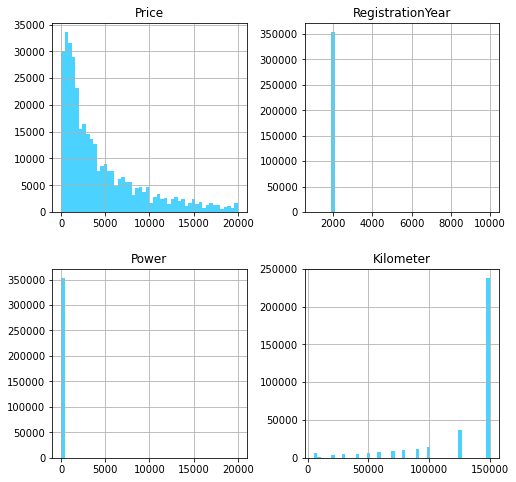

In [9]:
data.hist(figsize=(8, 8), bins=50, alpha=0.7, color='deepskyblue')
plt.show()

Аномалиями здесь можно считать неправдоподобные значения года регистрации, мощности автомобилей и нулевые значения признаков.

Построим диаграммы размаха («ящики с усами») по распределению численных данных при помощи метода *.boxplot*.

Поясним особенности этой диаграммы.

«Ящик» ограничен первым и третьим квартилями (нижняя и верхняя стороны прямоугольника - границы ящика). Внутри ящика зелёной линией обозначена медиана (второй квартиль).
«Усы» простираются вниз и вверх от границ ящика (чёрные линии ниже и выше границ ящика) на расстояние, равное 1,5 межквартильного размаха (сокращённо *IQR*, от англ. *interquartile range*, «межквартильный размах»). В размах «усов» попадают нормальные значения, а за пределами находятся выбросы, изображённые точками. Если верхний «ус» длиннее максимума, то он заканчивается максимумом. То же — для минимума и нижнего «уса».

**1. Диаграмма размаха по распределению цены автомобиля (евро) вместе с выбросами.**

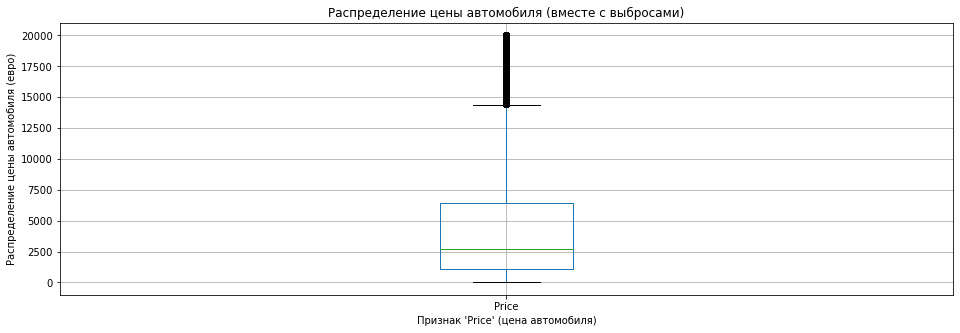

In [10]:
data.boxplot(column='Price', figsize=(16, 5))
plt.xlabel("Признак 'Price' (цена автомобиля)")
plt.ylabel('Распределение цены автомобиля (евро)')
plt.title('Распределение цены автомобиля (вместе с выбросами)')
plt.show()

**2. Диаграмма размаха по распределению года регистрации автомобиля вместе с выбросами.**

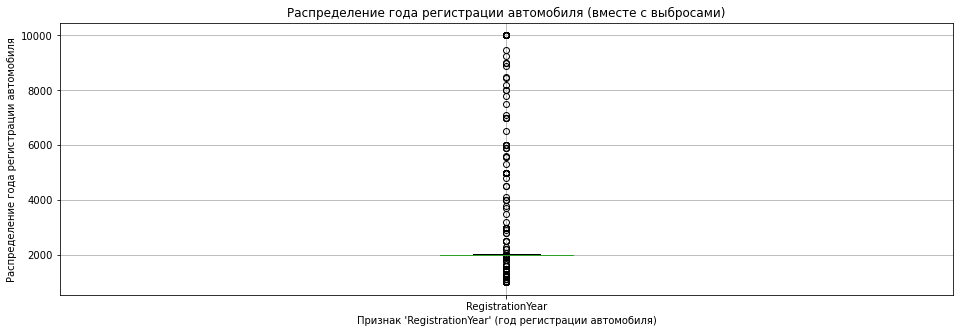

In [11]:
data.boxplot(column='RegistrationYear', figsize=(16, 5))
plt.xlabel("Признак 'RegistrationYear' (год регистрации автомобиля)")
plt.ylabel('Распределение года регистрации автомобиля')
plt.title('Распределение года регистрации автомобиля (вместе с выбросами)')
plt.show()

**3. Диаграмма размаха по распределению мощности автомобиля (л. с.) вместе с выбросами.**

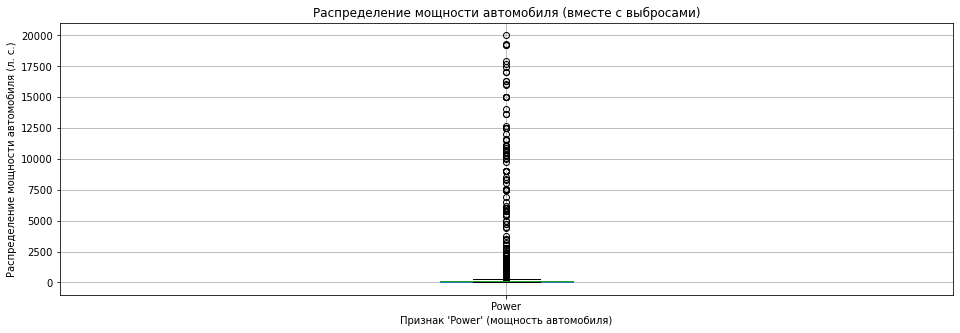

In [12]:
data.boxplot(column='Power', figsize=(16, 5))
plt.xlabel("Признак 'Power' (мощность автомобиля)")
plt.ylabel('Распределение мощности автомобиля (л. с.)')
plt.title('Распределение мощности автомобиля (вместе с выбросами)')
plt.show()

**4. Диаграмма размаха по распределению пробега автомобиля (км) вместе с выбросами.**

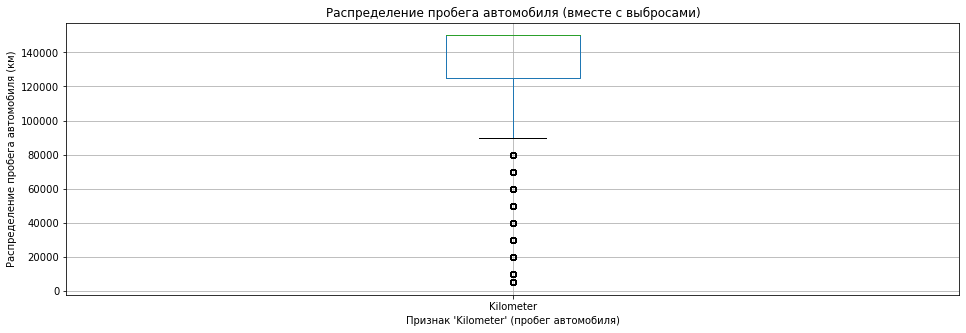

In [13]:
data.boxplot(column='Kilometer', figsize=(16, 5))
plt.xlabel("Признак 'Kilometer' (пробег автомобиля)")
plt.ylabel('Распределение пробега автомобиля (км)')
plt.title('Распределение пробега автомобиля (вместе с выбросами)')
plt.show()

Из-за выбросов сложно рассмотреть распределение внутри ящиков. Поэтому сделаем графики без выбросов, указав парамтер *showfliers=False*.

**1. Диаграмма размаха по распределению цены автомобиля (евро) без выбросов.**

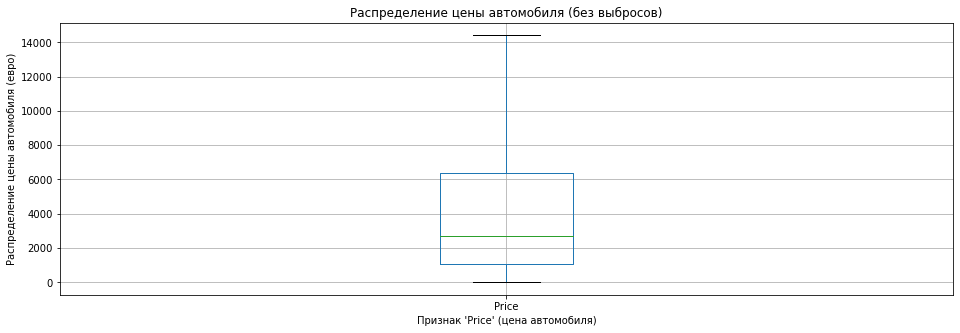

In [14]:
data.boxplot(column='Price', showfliers=False, figsize=(16, 5))
plt.xlabel("Признак 'Price' (цена автомобиля)")
plt.ylabel('Распределение цены автомобиля (евро)')
plt.title('Распределение цены автомобиля (без выбросов)')
plt.show()

**2. Диаграмма размаха по распределению года регистрации автомобиля без выбросов.**

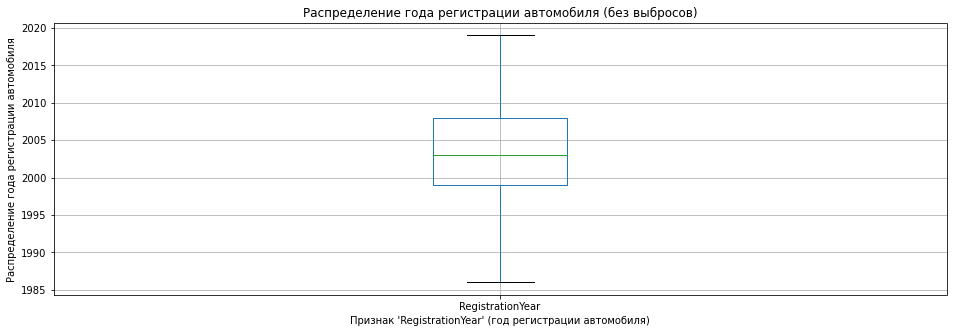

In [15]:
data.boxplot(column='RegistrationYear', showfliers=False, figsize=(16, 5))
plt.xlabel("Признак 'RegistrationYear' (год регистрации автомобиля)")
plt.ylabel('Распределение года регистрации автомобиля')
plt.title('Распределение года регистрации автомобиля (без выбросов)')
plt.show()

**3. Диаграмма размаха по распределению мощности автомобиля (л. с.) без выбросов.**

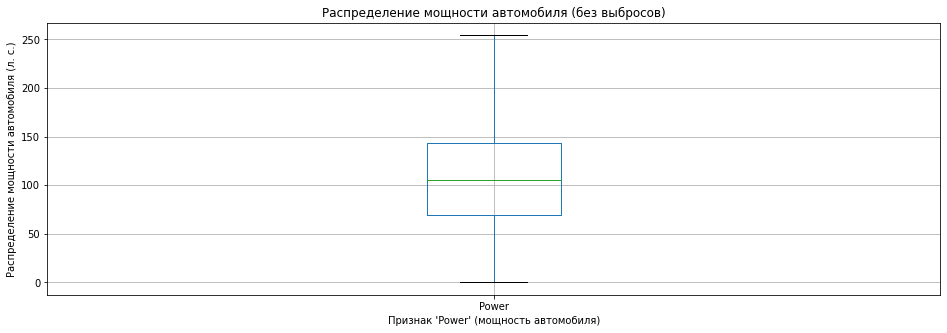

In [16]:
data.boxplot(column='Power', showfliers=False, figsize=(16, 5))
plt.xlabel("Признак 'Power' (мощность автомобиля)")
plt.ylabel('Распределение мощности автомобиля (л. с.)')
plt.title('Распределение мощности автомобиля (без выбросов)')
plt.show()

**4. Диаграмма размаха по распределению пробега автомобиля (км) без выбросов.**

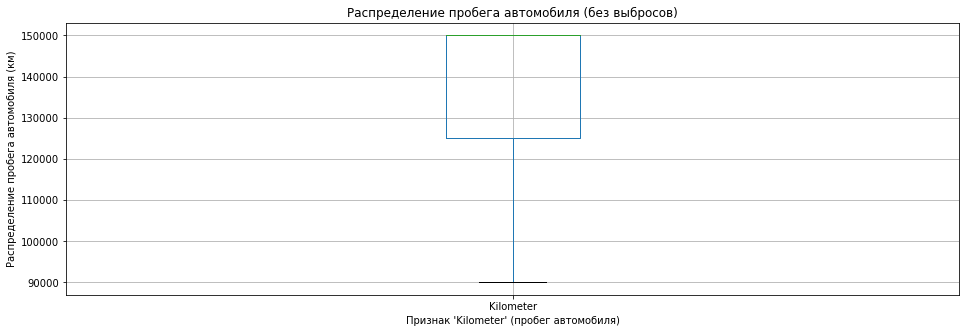

In [17]:
data.boxplot(column='Kilometer', showfliers=False, figsize=(16, 5))
plt.xlabel("Признак 'Kilometer' (пробег автомобиля)")
plt.ylabel('Распределение пробега автомобиля (км)')
plt.title('Распределение пробега автомобиля (без выбросов)')
plt.show()

Интересная ситуация получается для признака *Kilometer*: у него медиана и 75%-ый квартиль равны максимальному значению данных.

Выбросы в признаках *RegistrationYear* и *Power*, очевидно, необходимо корректировать.

Выведем коэффициенты корреляции Пирсона для переменных датасета.

In [18]:
data.corr()

,Price,RegistrationYear,Power,Kilometer
Price,1.000000,0.026916,0.158872,-0.333207
RegistrationYear,0.026916,1.000000,-0.000828,-0.053448
Power,0.158872,-0.000828,1.000000,0.024006
Kilometer,-0.333207,-0.053448,0.024006,1.000000


Построим тепловую карту (хитмэп) коэффициентов корреляции Пирсона для переменных датасета.


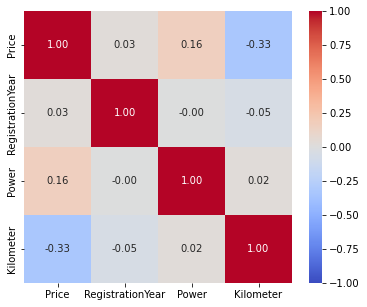

In [19]:
plt.figure(figsize=(6,5))
sns.heatmap(
    data.corr(), annot=True, fmt = '.2f', vmin=-1, vmax=1, center=0, cmap='coolwarm')
plt.show()

Наблюдается незначительная обратная корреляция между признаками *Kilometer* и *Price*, что логично. Чем больше пробег - тем ниже цена.

### Обработаем аномалии в столбцах

Посмотрим состав численных признаков *Price*, *RegistrationYear*, *Power* и *Kilometer*.

In [20]:
data[['Price', 'RegistrationYear', 'Power', 'Kilometer']].describe()

,Price,RegistrationYear,Power,Kilometer
count,354365.000000,354365.000000,354365.000000,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989
std,4514.176349,90.228466,189.851330,37905.083858
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


Аномалиями здесь можно считать неправдоподобные значения года регистрации автомобилей и нулевые значения признаков.

Посмотрим выборочно количество уникальных значений в признаках.

In [21]:
print(len(data['RegistrationYear'].unique()))
print(len(data['Model'].unique()))
print(len(data['Brand'].unique()))

151
251
40


Посмотрим содержание столбцов *DateCrawled*, *RegistrationYear* и *DateCreated*.

In [22]:
display(pd.read_csv(r'C:/Users/lorad/OneDrive/Documents/Моя папка/Data Science/Мои проекты/GitHubRepositories/'
                 'YandexPracticum/09_numerical methods_determining_the_cost_of_cars/autos.csv')[
    ['DateCrawled', 'RegistrationYear', 'DateCreated']])

,DateCrawled,RegistrationYear,DateCreated
0,2016-03-24 11:52:17,1993,2016-03-24 00:00:00
1,2016-03-24 10:58:45,2011,2016-03-24 00:00:00
2,2016-03-14 12:52:21,2004,2016-03-14 00:00:00
3,2016-03-17 16:54:04,2001,2016-03-17 00:00:00
4,2016-03-31 17:25:20,2008,2016-03-31 00:00:00
...,...,...,...
354364,2016-03-21 09:50:58,2005,2016-03-21 00:00:00
354365,2016-03-14 17:48:27,2005,2016-03-14 00:00:00
354366,2016-03-05 19:56:21,2000,2016-03-05 00:00:00
354367,2016-03-19 18:57:12,1996,2016-03-19 00:00:00


Даты скачивания и создания анкеты приходятся на 2016 год. Значит нужно удалить все строки, в которых автомобили были зарегистрированы позднее 2016 года.

Сохраним в датасете только те автомобили, год регистрации которых входит в диапазон с 1940 по 2016 гг.

In [23]:
data = data[(data['RegistrationYear'] <= 2016) & (data['RegistrationYear'] >= 1940)]
data

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
354364,0,NaN,2005,manual,0,colt,150000,petrol,mitsubishi,yes
354365,2200,NaN,2005,NaN,0,NaN,20000,NaN,sonstige_autos,NaN
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


Повторно посмотрим количество уникальных значений в признаках.

In [24]:
print(len(data['RegistrationYear'].unique()))
print(len(data['Model'].unique()))
print(len(data['Brand'].unique()))

77
251
40


После удаления аномалий уменьшилось количество уникальных значений в признаке *RegistrationYear*. При этом количество уникальных значений в признаке *Model* не изменилось, что означает, что мы сохранили в датасете все возможные модели автомобилей, включая ретро автомобили.

Удалим нули в столбце *Price*, поставим ограничение на значения в *Power* и сбросим индекс в датасете.

In [25]:
data = data[data['Price'] != 0]
data = data[data['Power'] <= 1500]
data = data.reset_index(drop=True)
data

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
329479,1150,bus,2000,manual,0,zafira,150000,petrol,opel,no
329480,2200,NaN,2005,NaN,0,NaN,20000,NaN,sonstige_autos,NaN
329481,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
329482,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


Посмотрим количество нулей в столбце *Power*.

In [26]:
data[data['Power'] == 0].shape

(32794, 10)

Заменим нули в столбце *Power* на медиану по бренду.

In [27]:
data.loc[data['Power'] == 0, 'Power'] = np.NaN
data['Power'] = data['Power'].fillna(
    data.groupby('Brand')['Power'].transform(lambda x: x.median() if x.median() else np.nan))
data[data['Power'] == 0].shape

(0, 10)

Повторно посмотрим количество уникальных значений в признаках.

In [28]:
print(len(data['RegistrationYear'].unique()))
print(len(data['Model'].unique()))
print(len(data['Brand'].unique()))

77
251
40


После удаления нулей количество уникальных значений в признаках *RegistrationYear* и *Model* не изменилось.

In [29]:
data[['Price', 'RegistrationYear', 'Power', 'Kilometer']].describe()

,Price,RegistrationYear,Power,Kilometer
count,329484.000000,329484.000000,329484.000000,329484.000000
mean,4607.664491,2002.620088,120.140456,128231.067366
std,4546.198371,6.771335,55.971133,37486.631643
min,1.000000,1940.000000,1.000000,5000.000000
25%,1200.000000,1999.000000,80.000000,125000.000000
50%,2900.000000,2003.000000,109.000000,150000.000000
75%,6600.000000,2007.000000,150.000000,150000.000000
max,20000.000000,2016.000000,1500.000000,150000.000000


### Заполним пропущенные значения в столбцах

Модель градиентного бустинга *Catboost* не распознаёт тип данных *NaN*, поэтому для её применения в датасете необходимо заполнить пропуски.

Пропуски имеются у следующих признаков:
- *VehicleType* - тип автомобильного кузова,
- *Gearbox* - тип коробки передач,
- *Model* - модель автомобиля,
- *FuelType* - тип топлива,
- *Repaired* - была машина в ремонте или нет.

In [30]:
data.isna().sum()

Price                   0
VehicleType         19884
RegistrationYear        0
Gearbox             15542
Power                   0
Model               15573
Kilometer               0
FuelType            24099
Brand                   0
Repaired            59751
dtype: int64

Посмотрим состав признаков с пропусками.

In [31]:
data['VehicleType'].value_counts()

sedan          89334
small          77970
wagon          63652
bus            28328
convertible    19846
coupe          15621
suv            11784
other           3065
Name: VehicleType, dtype: int64

In [32]:
data['Gearbox'].value_counts()

manual    250987
auto       62955
Name: Gearbox, dtype: int64

In [33]:
data['Model'].value_counts()

golf                  26723
other                 23142
3er                   18663
polo                  12023
corsa                 11586
                      ...  
kalina                    6
rangerover                3
serie_3                   3
range_rover_evoque        2
serie_1                   1
Name: Model, Length: 250, dtype: int64

In [34]:
data['Model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'c_max',
       '3_reihe', 'passat', 'navara', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'arosa', 'other', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'one', 'fortwo',
       '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta', 'fiesta',
       'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'ka', 'a1', 'insignia',
       'combo', 'focus', 'tt', 'corsa', 'a6', 'jazz', 'omega', 'slk',
       '7er', '80', '147', '100', 'z_reihe', 'sorento', 'v40', 'ibiza',
       'mustang', 'eos', 'touran', 'getz', 'a3', 'almera', 'megane',
       'lupo', 'r19', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'sharan', '6_reihe', 'c4', 'panda',
       'up', 'i_reihe', 'ceed', '5_reihe', 'yeti', 'octavia', 'zafira',
       'mii', 'rx_reihe', '6er', 'modus', 'fox', 'matiz', 'beetle', 'c1',
       'rio', 'to

In [35]:
data['FuelType'].value_counts()

petrol      204561
gasoline     94803
lpg           5021
cng            531
hybrid         220
other          162
electric        87
Name: FuelType, dtype: int64

In [36]:
data['Repaired'].value_counts()

no     236809
yes     32924
Name: Repaired, dtype: int64

Введём отдельную переменную *data_pass*, в которую сохраним копию преобразованного ранее исходного датасета. В новом датасете мы заполним пропущенные значения в столбцах.

У признаков *VehicleType*, *Model* и *FuelType* одним из значений является *'other'*, поэтому заменим пропуски в этих столбцах на дополнительную категорию *'another'*.

In [37]:
data_pass = data.copy()
data_pass['VehicleType'] = data_pass['VehicleType'].fillna('another')
data_pass['Model'] = data_pass['Model'].fillna('another')
data_pass['FuelType'] = data_pass['FuelType'].fillna('another')
data_pass

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,another,1993,manual,101.0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190.0,another,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163.0,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69.0,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
329479,1150,bus,2000,manual,101.0,zafira,150000,petrol,opel,no
329480,2200,another,2005,NaN,140.0,another,20000,another,sonstige_autos,NaN
329481,1199,convertible,2000,auto,101.0,fortwo,125000,petrol,smart,no
329482,9200,bus,1996,manual,102.0,transporter,150000,gasoline,volkswagen,no


Категориальные признаки *Gearbox* и *Repaired* принимают только два значения, т.е. являются бинарными. Для работы модели необходимы численные признаки, поэтому мы можем преобразовать значения этих признаков в числа *'0'* и *'1'*.

Сначала заполним пропуски в признаках *Gearbox* и *Repaired* случайными числами *'0'* или *'1'*. Для этого применим функцию *randint*, которая генерирует целые случайные числа в заданном диапазоне.

In [38]:
data_pass['Gearbox'] = data_pass['Gearbox'].fillna(
    pd.Series(np.random.randint(0, 2, size=len(data_pass)), index=data_pass.index))
data_pass['Repaired'] = data_pass['Repaired'].fillna(
    pd.Series(np.random.randint(0, 2, size=len(data_pass)), index=data_pass.index))

print(data_pass['Gearbox'].unique())
print(data_pass['Repaired'].unique())
display(data_pass)

['manual' 'auto' 1 0]
[0 'yes' 'no' 1]


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,another,1993,manual,101.0,golf,150000,petrol,volkswagen,0
1,18300,coupe,2011,manual,190.0,another,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163.0,grand,125000,gasoline,jeep,0
3,1500,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69.0,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
329479,1150,bus,2000,manual,101.0,zafira,150000,petrol,opel,no
329480,2200,another,2005,0,140.0,another,20000,another,sonstige_autos,0
329481,1199,convertible,2000,auto,101.0,fortwo,125000,petrol,smart,no
329482,9200,bus,1996,manual,102.0,transporter,150000,gasoline,volkswagen,no


Проверим датасет на наличие пропусков:

In [39]:
data_pass.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

Затем преобразуем исходные категориальные значения признаков *Gearbox* и *Repaired* в числа *'0'* и *'1'*.

Для признака *Gearbox* обозначим:
- *'0'* - для *'manual'*,
- *'1'* - для *'auto'*.

Для признака *Repaired* обозначим:
- *'0'* - для *'no'*,
- *'1'* - для *'yes'*.

In [40]:
data_pass.loc[data_pass['Gearbox'] == 'manual', 'Gearbox'] = 0
data_pass.loc[data_pass['Gearbox'] == 'auto', 'Gearbox'] = 1

data_pass.loc[data_pass['Repaired'] == 'no', 'Repaired'] = 0
data_pass.loc[data_pass['Repaired'] == 'yes', 'Repaired'] = 1

display(data_pass)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,another,1993,0,101.0,golf,150000,petrol,volkswagen,0
1,18300,coupe,2011,0,190.0,another,125000,gasoline,audi,1
2,9800,suv,2004,1,163.0,grand,125000,gasoline,jeep,0
3,1500,small,2001,0,75.0,golf,150000,petrol,volkswagen,0
4,3600,small,2008,0,69.0,fabia,90000,gasoline,skoda,0
...,...,...,...,...,...,...,...,...,...,...
329479,1150,bus,2000,0,101.0,zafira,150000,petrol,opel,0
329480,2200,another,2005,0,140.0,another,20000,another,sonstige_autos,0
329481,1199,convertible,2000,1,101.0,fortwo,125000,petrol,smart,0
329482,9200,bus,1996,0,102.0,transporter,150000,gasoline,volkswagen,0


Преобразуем тип данных у признаков *Gearbox* и *Repaired* в *integer*:

In [41]:
data_pass['Gearbox'] = data_pass['Gearbox'].astype('int')
data_pass['Repaired'] = data_pass['Repaired'].astype('int')

In [42]:
data_pass.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329484 entries, 0 to 329483
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             329484 non-null  int64  
 1   VehicleType       329484 non-null  object 
 2   RegistrationYear  329484 non-null  int64  
 3   Gearbox           329484 non-null  int32  
 4   Power             329484 non-null  float64
 5   Model             329484 non-null  object 
 6   Kilometer         329484 non-null  int64  
 7   FuelType          329484 non-null  object 
 8   Brand             329484 non-null  object 
 9   Repaired          329484 non-null  int32  
dtypes: float64(1), int32(2), int64(3), object(4)
memory usage: 22.6+ MB


Данные (*_pass*) подготовлены для обучения модели градиентного бустинга *Catboost*.

### Исследуем данные после итоговой предобработки

Посмотрим описание данных в итоговом датасете *data_pass*.

In [43]:
data_pass.describe()

,Price,RegistrationYear,Gearbox,Power,Kilometer,Repaired
count,329484.000000,329484.000000,329484.000000,329484.000000,329484.000000,329484.000000
mean,4607.664491,2002.620088,0.214514,120.140456,128231.067366,0.190968
std,4546.198371,6.771335,0.410486,55.971133,37486.631643,0.393065
min,1.000000,1940.000000,0.000000,1.000000,5000.000000,0.000000
25%,1200.000000,1999.000000,0.000000,80.000000,125000.000000,0.000000
50%,2900.000000,2003.000000,0.000000,109.000000,150000.000000,0.000000
75%,6600.000000,2007.000000,0.000000,150.000000,150000.000000,0.000000
max,20000.000000,2016.000000,1.000000,1500.000000,150000.000000,1.000000


При помощи гистограмм визуализируем распределение переменных в итоговом датасете *data_pass*.

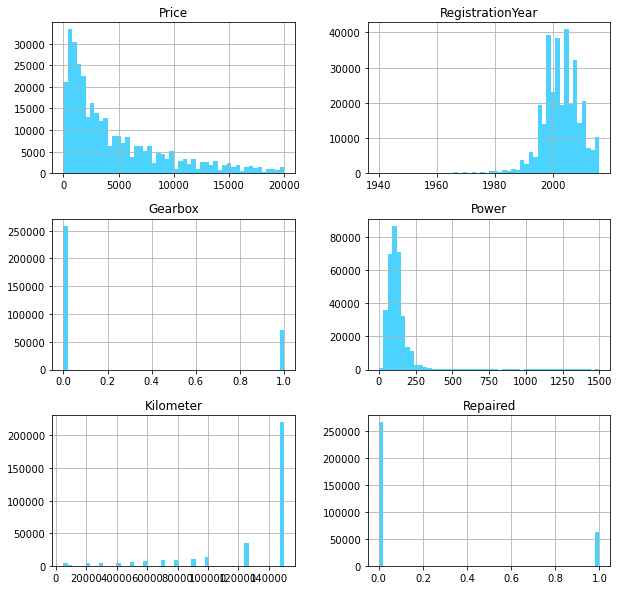

In [44]:
data_pass.hist(figsize=(10, 10), bins=50, alpha=0.7, color='deepskyblue')
plt.show()

Выведем коэффициенты корреляции Пирсона для переменных итогового датасета *data_pass*.

In [45]:
data_pass.corr()

,Price,RegistrationYear,Gearbox,Power,Kilometer,Repaired
Price,1.000000,0.447416,0.223838,0.459619,-0.354344,-0.234623
RegistrationYear,0.447416,1.000000,0.029291,0.113172,-0.231562,-0.117103
Gearbox,0.223838,0.029291,1.000000,0.360498,0.008336,-0.010166
Power,0.459619,0.113172,0.360498,1.000000,0.091374,-0.062332
Kilometer,-0.354344,-0.231562,0.008336,0.091374,1.000000,0.075745
Repaired,-0.234623,-0.117103,-0.010166,-0.062332,0.075745,1.000000


Построим тепловую карту (хитмэп) коэффициентов корреляции Пирсона для переменных датасета *data_pass*.

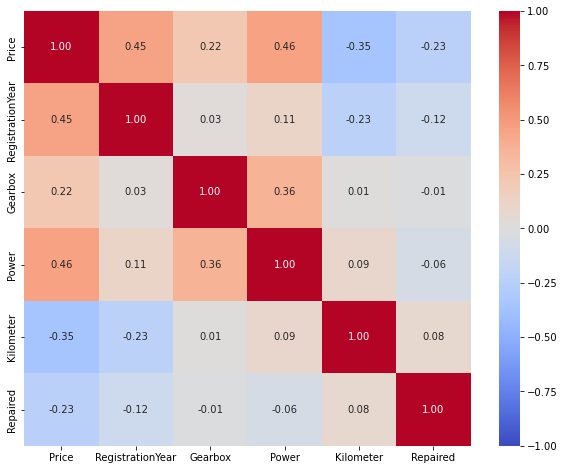

In [46]:
plt.figure(figsize=(10,8))
sns.heatmap(
    data_pass.corr(), annot=True, fmt = '.2f', vmin=-1, vmax=1, center=0, cmap='coolwarm')
plt.show()

Наблюдается незначительная прямая корреляция между признаками *RegistrationYear*, *Power* и *Price*, а также обратная корреляция между признаками *Kilometer* и *Price*, что логично. Чем новее автомобиль и больше мощность, тем выше цена. И, наоборот, чем больше пробег - тем ниже цена.

**Вывод**. 

В этом разделе были выполнены следующие задачи:
1. неинформативные признаки и явные дубликаты удалены;
2. аномалии в столбцах обработаны;
3. заполнены пропущенные значения в столбцах, и полученный датасет сохранён в отдельную переменную *data_pass*.

В результате выполнения задач этого раздела было выявлено следующее:
- после итоговой предобработки данных корреляция между признаками, в целом, по-прежнему отсутствует;
- распределения значений признаков стали более правдоподобными.

Таким образом, данные подготовлены для дальнейшей работы.

## Обучение моделей

### Подготовим выборки для обучения моделей

#### Подготовим выборки из датасета ***data_pass*** с заполненными пропущенными значениями.

In [47]:
# Разобьём данные, выделив целевой признак:
features_pass = data_pass.drop('Price', axis=1)
target_pass = data_pass['Price']

Разделим данные на обучающую, валидационную и тестовую выборки в пропорции 3:1:1.

In [48]:
# Разделим полученые данные на обучающую выборку для применения Grid Search (train_grid) и тестовую выборку (20%):
features_pass_train_grid, features_pass_test, target_pass_train_grid, target_pass_test = train_test_split(
    features_pass, target_pass, test_size=0.20, random_state=RANDOM_STATE)

In [49]:
# Разделим обучающую выборку для Grid Search (train_grid) на обычную обучающую и валидационную 
# (25% от обучающей выборки для Grid Search = 20% от исходного датасета):
features_pass_train, features_pass_valid, target_pass_train, target_pass_valid = train_test_split(
    features_pass_train_grid, target_pass_train_grid, test_size=0.25, random_state=RANDOM_STATE)

Данные из датасета *data_pass* подготовлены для модели градиентного бустинга *CatBoost*, т.к. *CatBoost* не распознаёт тип данных *NaN*.

#### Преобразуем категориальные признаки в численные

Модели градиентного бустинга *LightGBM* и *случайного леса* не распознают тип данных *object* (присутствующие в датасете *data_pass*), поэтому для их применения необходимо преобразовать категориальные признаки в численные.

Посмотрим, какие категориальные признаки нужно преобразовать в численные.

In [50]:
data_pass.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329484 entries, 0 to 329483
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             329484 non-null  int64  
 1   VehicleType       329484 non-null  object 
 2   RegistrationYear  329484 non-null  int64  
 3   Gearbox           329484 non-null  int32  
 4   Power             329484 non-null  float64
 5   Model             329484 non-null  object 
 6   Kilometer         329484 non-null  int64  
 7   FuelType          329484 non-null  object 
 8   Brand             329484 non-null  object 
 9   Repaired          329484 non-null  int32  
dtypes: float64(1), int32(2), int64(3), object(4)
memory usage: 22.6+ MB


Итак, в численные данные необходимо преобразовать признаки *VehicleType*, *Model*, *FuelType* и *Brand*.

Преобразуем категориальные признаки в численные на обычной обучающей выборке и обучающей выборке для *Grid Search* с помощью техники порядкового кодирования *(Ordinal Encoding)*.

Введём отдельные переменные *features_ordinal_scaler_train*, *features_ordinal_scaler_valid*, *features_ordinal_scaler_train_grid* и *features_ordinal_scaler_test*, в которые сохраним копии преобразованных ранее признаков *features_pass_train*, *features_pass_valid*, *features_pass_train_grid* и *features_pass_test* для обычной обучающей выборки и обучающей выборки для *Grid Search*. В новых датасетах мы преобразуем категориальные признаки в численные с помощью техники порядкового кодирования и масштабируем численные признаки.

In [51]:
# выполним порядковое кодирование:

categorical_features = [
    'VehicleType', 
    'Model', 
    'FuelType', 
    'Brand',
]

features_ordinal_scaler_train = features_pass_train.copy()
features_ordinal_scaler_valid = features_pass_valid.copy()
features_ordinal_scaler_train_grid = features_pass_train_grid.copy()
features_ordinal_scaler_test = features_pass_test.copy()

# создаём объект структуры данных OrdinalEncoder()
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1) 

# Для моделей без Grid Search:
# на обучающих данных получим список категориальных признаков с помощью метода fit() и преобразуем данные с помощью transform()
features_ordinal_scaler_train[categorical_features] = encoder.fit_transform(
    features_ordinal_scaler_train[categorical_features])
# преобразуем данные на валидационной выборке
features_ordinal_scaler_valid[categorical_features] = encoder.transform(
    features_ordinal_scaler_valid[categorical_features])

# Для моделей с Grid Search:
# на обучающих данных получим список категориальных признаков с помощью метода fit() и преобразуем данные с помощью transform()
features_ordinal_scaler_train_grid[categorical_features] = encoder.fit_transform(
    features_ordinal_scaler_train_grid[categorical_features])

# Для всех моделей:
# преобразуем данные на тестовой выборке
features_ordinal_scaler_test[categorical_features] = encoder.transform(
    features_ordinal_scaler_test[categorical_features])

# выведем датафреймы
display("Выборка 'train'", features_ordinal_scaler_train.head())
display("Выборка 'valid'", features_ordinal_scaler_valid.head())
display("Выборка 'train_grid'", features_ordinal_scaler_train_grid.head())
display("Выборка 'test'", features_ordinal_scaler_test.head())

"Выборка 'train'"

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
125012,1.0,2007,0,131.0,225.0,20000,3.0,38.0,0
182425,8.0,2000,0,118.0,11.0,150000,7.0,2.0,0
163684,6.0,2006,0,54.0,108.0,90000,7.0,38.0,0
3710,0.0,1995,1,150.0,167.0,150000,0.0,20.0,0
49395,6.0,2002,0,58.0,84.0,125000,7.0,24.0,0


"Выборка 'valid'"

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
137448,7.0,2008,1,141.0,181.0,100000,7.0,23.0,0
232741,2.0,2008,1,230.0,62.0,150000,7.0,39.0,0
147158,5.0,2009,0,80.0,117.0,80000,7.0,38.0,0
329159,2.0,1995,0,75.0,117.0,150000,7.0,38.0,0
80833,7.0,2011,0,178.0,167.0,80000,3.0,22.0,0


"Выборка 'train_grid'"

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
3013,5.0,2008,0,344.0,141.0,125000,7.0,30.0,0
171444,2.0,1997,1,193.0,209.0,80000,7.0,20.0,0
106679,5.0,2006,0,177.0,15.0,150000,7.0,2.0,0
314549,6.0,2001,0,101.0,129.0,150000,0.0,10.0,0
36844,6.0,2000,0,75.0,40.0,150000,7.0,33.0,0


"Выборка 'test'"

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
191192,0.0,1970,1,90.0,40.0,100000,0.0,24.0,0
632,5.0,2010,0,170.0,60.0,90000,3.0,20.0,0
162535,6.0,2009,0,60.0,170.0,50000,7.0,9.0,0
219412,6.0,2001,0,50.0,144.0,80000,7.0,38.0,0
264597,5.0,2002,0,75.0,117.0,150000,7.0,38.0,0


#### Масштабируем численные признаки

In [52]:
# выделим численные признаки, которые необходимо масштабировать
numeric = ['VehicleType', 'RegistrationYear', 'Power', 'Model', 'Kilometer', 'FuelType', 'Brand']

pd.options.mode.chained_assignment = None

# создаём объект структуры данных StandardScaler()
scaler = StandardScaler() 

# Для моделей без Grid Search:
# настроим объект на обучающих данных (вычислим среднее и дисперсию) с помощью метода fit()
scaler.fit(features_ordinal_scaler_train[numeric])
# преобразуем данные на обучающей и валидационной выборках
features_ordinal_scaler_train[numeric] = scaler.transform(features_ordinal_scaler_train[numeric])
features_ordinal_scaler_valid[numeric] = scaler.transform(features_ordinal_scaler_valid[numeric])

# Для моделей с Grid Search:
# настроим объект на обучающих данных (вычислим среднее и дисперсию) с помощью метода fit()
scaler.fit(features_ordinal_scaler_train_grid[numeric])
# преобразуем данные на обучающей выборке
features_ordinal_scaler_train_grid[numeric] = scaler.transform(features_ordinal_scaler_train_grid[numeric])

# Для всех моделей:
# преобразуем данные на тестовой выборке
features_ordinal_scaler_test[numeric] = scaler.transform(features_ordinal_scaler_test[numeric])

# выведем датафреймы
display("Выборка 'train'", features_ordinal_scaler_train.head())
display("Выборка 'valid'", features_ordinal_scaler_valid.head())
display("Выборка 'train_grid'", features_ordinal_scaler_train_grid.head())
display("Выборка 'test'", features_ordinal_scaler_test.head())

"Выборка 'train'"

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
125012,-1.654674,0.648150,0,0.198837,1.674312,-2.885209,-0.987591,1.292784,0
182425,1.268714,-0.385121,0,-0.035805,-1.346951,0.581310,0.732959,-1.416385,0
163684,0.433460,0.500540,0,-1.190968,0.022500,-1.018622,0.732959,1.292784,0
3710,-2.072300,-1.123172,1,0.541776,0.855465,0.581310,-2.278004,-0.061801,0
49395,0.433460,-0.089900,0,-1.118770,-0.316333,-0.085328,0.732959,0.239218,0


"Выборка 'valid'"

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
137448,0.851087,0.795761,1,0.379331,1.053118,-0.751966,0.732959,0.163963,0
232741,-1.237047,0.795761,1,1.985729,-0.626930,0.581310,0.732959,1.368039,0
147158,0.015833,0.943371,0,-0.721683,0.149563,-1.285277,0.732959,1.292784,0
329159,-1.237047,-1.123172,0,-0.811930,0.149563,0.581310,0.732959,1.292784,0
80833,0.851087,1.238591,0,1.047160,0.855465,-1.285277,-0.987591,0.088709,0


"Выборка 'train_grid'"

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
3013,0.017428,0.795424,0,4.015624,0.487319,-0.086436,0.733813,0.689971,0
171444,-1.234430,-0.830153,1,1.307973,1.446049,-1.287022,0.733813,-0.062175,0
106679,0.017428,0.499864,0,1.021070,-1.289152,0.580556,0.733813,-1.416038,0
314549,0.434714,-0.239034,0,-0.341721,0.318131,0.580556,-2.275849,-0.814321,0
36844,0.434714,-0.386814,0,-0.807939,-0.936678,0.580556,0.733813,0.915614,0


"Выборка 'test'"

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
191192,-2.069002,-4.820207,1,-0.538967,-0.936678,-0.753428,-2.275849,0.238683,0
632,0.017428,1.090983,0,0.895550,-0.654698,-1.020225,-0.985994,-0.062175,0
162535,0.434714,0.943204,0,-1.076911,0.896189,-2.087412,0.733813,-0.889536,0
219412,0.434714,-0.239034,0,-1.256226,0.529616,-1.287022,0.733813,1.291687,0
264597,0.017428,-0.091255,0,-0.807939,0.148943,0.580556,0.733813,1.291687,0


In [53]:
features_ordinal_scaler_train_grid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263587 entries, 3013 to 217570
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   VehicleType       263587 non-null  float64
 1   RegistrationYear  263587 non-null  float64
 2   Gearbox           263587 non-null  int32  
 3   Power             263587 non-null  float64
 4   Model             263587 non-null  float64
 5   Kilometer         263587 non-null  float64
 6   FuelType          263587 non-null  float64
 7   Brand             263587 non-null  float64
 8   Repaired          263587 non-null  int32  
dtypes: float64(7), int32(2)
memory usage: 18.1 MB


In [54]:
features_ordinal_scaler_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197690 entries, 125012 to 231073
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   VehicleType       197690 non-null  float64
 1   RegistrationYear  197690 non-null  float64
 2   Gearbox           197690 non-null  int32  
 3   Power             197690 non-null  float64
 4   Model             197690 non-null  float64
 5   Kilometer         197690 non-null  float64
 6   FuelType          197690 non-null  float64
 7   Brand             197690 non-null  float64
 8   Repaired          197690 non-null  int32  
dtypes: float64(7), int32(2)
memory usage: 13.6 MB


Масштабированные признаки (*_ordinal_scaler*) подготовлены для обучения моделей градиентного бустинга *LightGBM* и *случайного леса*.

### Обучим разные модели

Обучим разные модели, одна из которых — *LightGBM*, как минимум одна — не бустинг. Для каждой модели попробуем разные гиперпараметры.

Для наглядности напишу ниже какие переменные (выборки), где и почему я буду использовать далее для обучения моделей.

Для LightGBM (+ object) и случайного леса:

- **features_ordinal_scaler_train**
- target_pass_train
- **features_ordinal_scaler_valid**
- target_pass_valid
-
- **features_ordinal_scaler_train_grid**
- target_pass_train_grid
- **features_ordinal_scaler_test**
- target_pass_test


Для Catboost (+ NaN):

- **features_pass_train**
- target_pass_train
- features_pass_valid
- target_pass_valid
-
- **features_pass_train_grid**
- target_pass_train_grid
- features_pass_test
- target_pass_test

In [55]:
# задаём параметры для кроссвалидации
kf = KFold(n_splits=5, random_state=RANDOM_STATE, shuffle=True)

#### Модель градиентного бустинга ***LightGBM*** для задачи регрессии

Для модели градиентного бустинга *LightGBM* возьмём преобразованные данные *_ordinal_scaler*, т.к. модель *LightGBM* не распознаёт тип данных *object*.

In [56]:
%%time


# создадим модель LightGBM для задачи регрессии:
model_lgbm = LGBMRegressor(
    num_boost_round=300, # количество деревьев (итераций)
    max_depth=10, # максимальная глубина дерева
    random_state=RANDOM_STATE, 
    learning_rate=0.15, # коэффициент скорости обучения (размер шага градиентного спуска)
    early_stopping_rounds=10, # контроль переобучения
)

# обучим модель:
start = time.time() # старт отсчёта времени обучения
model_lgbm.fit(features_ordinal_scaler_train, target_pass_train, 
               eval_set=[(features_ordinal_scaler_valid, target_pass_valid),], 
               eval_metric='rmse', 
               verbose=10)
end = time.time() # отметка завершения отсчёта времени обучения
fit_time_lgbm = end - start # время обучения модели

# получим предсказания:
predictions = model_lgbm.predict(features_ordinal_scaler_valid)
predict_time_lgbm = time.time() - end # время предсказания

# получим метрику RMSE:
rmse_lgbm = mean_squared_error(
    target_pass_valid, predictions, squared=False) # параметр squared=False возвращает RMSE

print('RMSE модели LightGBM:', f'{rmse_lgbm:.0f}')
print('Время обучения модели:', f'{fit_time_lgbm:.2f} s')
print('Время предсказания модели:', f'{predict_time_lgbm:.2f} s')

[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[10]	valid_0's rmse: 2321.84	valid_0's l2: 5.39093e+06
[20]	valid_0's rmse: 1970.62	valid_0's l2: 3.88334e+06
[30]	valid_0's rmse: 1869.87	valid_0's l2: 3.4964e+06
[40]	valid_0's rmse: 1823.57	valid_0's l2: 3.32539e+06
[50]	valid_0's rmse: 1795.23	valid_0's l2: 3.22284e+06
[60]	valid_0's rmse: 1774.08	valid_0's l2: 3.14735e+06
[70]	valid_0's rmse: 1759.77	valid_0's l2: 3.0968e+06
[80]	valid_0's rmse: 1747.68	valid_0's l2: 3.05438e+06
[90]	valid_0's rmse: 1736.21	valid_0's l2: 3.01444e+06
[100]	valid_0's rmse: 1726.85	valid_0's l2: 2.98201e+06
[110]	valid_0's rmse: 1719.52	valid_0's l2: 2.95675e+06
[120]	valid_0's rmse: 1712.55	valid_0's l2: 2.93284e+06
[130]	valid_0's rmse: 1706.9	valid_0's l2: 2.91352e+06
[140]	valid_0's rmse: 1701.45	v

Модель градиентного бустинга ***LightGBM*** имеет метрику оценки качества ***RMSE = 1654*** при количестве деревьев (итераций) *num_boost_round = 300* и глубине дерева *max_depth = 10*.

Время обучения модели: ***1.12 s***.

Время предсказания модели: ***0.12 s***.

#### Модель градиентного бустинга ***LightGBM*** для задачи регрессии с ***Grid Search***

Для модели градиентного бустинга *LightGBM* возьмём преобразованные данные *_ordinal_scaler*, т.к. модель *LightGBM* не распознаёт тип данных *object*.

In [57]:
%%time


# создадим модель LightGBM для задачи регрессии:
model_lgbm_gscv = LGBMRegressor(random_state=RANDOM_STATE)

# создадим словарь с гиперпараметрами для модели:
parameters = { 'metric': ['rmse'], # рассчитываемая метрика
              'boosting_type': ['gbdt'], # ['dart'] (тип алгоритма)
              'n_estimators': [200, 400], # количество деревьев
              'max_depth': [6, 8] } # максимальная глубина дерева

# подберём гиперпараметры с помощью GridSearchCV:
lgbm_gscv_result = GridSearchCV(model_lgbm_gscv, parameters, cv=kf, scoring='neg_root_mean_squared_error', verbose=50)

# обучим модель:
lgbm_gscv_result.fit(features_ordinal_scaler_train_grid, target_pass_train_grid)

# получим предсказания:
predictions = lgbm_gscv_result.predict(features_ordinal_scaler_train_grid)


print('RMSE наилучшей модели LightGBM c GridSearchCV:', f'{abs(lgbm_gscv_result.best_score_):.0f}')
print('Наилучшая модель LightGBM c GridSearchCV:', lgbm_gscv_result.best_estimator_)
print('Параметры наилучшей модели LightGBM c GridSearchCV:', lgbm_gscv_result.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START boosting_type=gbdt, max_depth=6, metric=rmse, n_estimators=200
[CV 1/5; 1/4] END boosting_type=gbdt, max_depth=6, metric=rmse, n_estimators=200;, score=-1717.520 total time=   0.7s
[CV 2/5; 1/4] START boosting_type=gbdt, max_depth=6, metric=rmse, n_estimators=200
[CV 2/5; 1/4] END boosting_type=gbdt, max_depth=6, metric=rmse, n_estimators=200;, score=-1720.852 total time=   0.8s
[CV 3/5; 1/4] START boosting_type=gbdt, max_depth=6, metric=rmse, n_estimators=200
[CV 3/5; 1/4] END boosting_type=gbdt, max_depth=6, metric=rmse, n_estimators=200;, score=-1717.899 total time=   0.8s
[CV 4/5; 1/4] START boosting_type=gbdt, max_depth=6, metric=rmse, n_estimators=200
[CV 4/5; 1/4] END boosting_type=gbdt, max_depth=6, metric=rmse, n_estimators=200;, score=-1718.004 total time=   0.8s
[CV 5/5; 1/4] START boosting_type=gbdt, max_depth=6, metric=rmse, n_estimators=200
[CV 5/5; 1/4] END boosting_type=gbdt, max_depth=6, me

In [58]:
# 1-й способ узнать время обучения и предсказания модели:
lgbm_gscv_res = pd.DataFrame(lgbm_gscv_result.cv_results_).sort_values(by='rank_test_score')
lgbm_gscv_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_boosting_type,param_max_depth,param_metric,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,1.450430,0.058255,0.140803,0.008634,gbdt,8,rmse,400,"{'boosting_type': 'gbdt', 'max_depth': 8, 'met...",-1661.108927,-1664.056666,-1654.041828,-1662.331697,-1658.209333,-1659.949690,3.516155,1
1,1.249485,0.128485,0.132104,0.010614,gbdt,6,rmse,400,"{'boosting_type': 'gbdt', 'max_depth': 6, 'met...",-1673.285574,-1676.363758,-1666.630556,-1679.462026,-1669.880756,-1673.124534,4.547003,2
2,0.812020,0.065505,0.070203,0.010147,gbdt,8,rmse,200,"{'boosting_type': 'gbdt', 'max_depth': 8, 'met...",-1705.591665,-1708.227075,-1703.670968,-1703.577929,-1702.359189,-1704.685365,2.050931,3
0,0.760175,0.063439,0.076602,0.010819,gbdt,6,rmse,200,"{'boosting_type': 'gbdt', 'max_depth': 6, 'met...",-1717.519897,-1720.851949,-1717.899196,-1718.003760,-1713.131642,-1717.481289,2.479108,4


In [59]:
# 2-й способ узнать время обучения и предсказания модели:
lgbm_gscv_res2 = pd.DataFrame(lgbm_gscv_result.cv_results_).iloc[lgbm_gscv_result.best_index_]
lgbm_gscv_res2

mean_fit_time                                                    1.45043
std_fit_time                                                    0.058255
mean_score_time                                                 0.140803
std_score_time                                                  0.008634
param_boosting_type                                                 gbdt
param_max_depth                                                        8
param_metric                                                        rmse
param_n_estimators                                                   400
params                 {'boosting_type': 'gbdt', 'max_depth': 8, 'met...
split0_test_score                                           -1661.108927
split1_test_score                                           -1664.056666
split2_test_score                                           -1654.041828
split3_test_score                                           -1662.331697
split4_test_score                                  

In [60]:
print('Время обучения модели:', f'{lgbm_gscv_res.iloc[0]["mean_fit_time"]:.2f} s')
print('Время предсказания модели:', f'{lgbm_gscv_res.iloc[0]["mean_score_time"]:.2f} s')

Время обучения модели: 1.45 s
Время предсказания модели: 0.14 s


Наилучшая модель градиентного бустинга ***LightGBM*** с *GridSearchCV* имеет метрику оценки качества ***RMSE = 1660*** при количестве деревьев (итераций) *n_estimators = 400* и глубине дерева *max_depth = 8*.

Время обучения модели: ***1.45 s***.

Время предсказания модели: ***0.14 s***.

#### Модель градиентного бустинга ***CatBoost*** для задачи регрессии

Для модели градиентного бустинга *CatBoost* возьмём данные из датасета *data_pass* c заполненными пропусками, т.к. модель *CatBoost* не распознаёт тип данных *NaN*.

In [61]:
data_pass.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329484 entries, 0 to 329483
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             329484 non-null  int64  
 1   VehicleType       329484 non-null  object 
 2   RegistrationYear  329484 non-null  int64  
 3   Gearbox           329484 non-null  int32  
 4   Power             329484 non-null  float64
 5   Model             329484 non-null  object 
 6   Kilometer         329484 non-null  int64  
 7   FuelType          329484 non-null  object 
 8   Brand             329484 non-null  object 
 9   Repaired          329484 non-null  int32  
dtypes: float64(1), int32(2), int64(3), object(4)
memory usage: 22.6+ MB


In [62]:
# выделим категориальные признаки в датасете data_pass
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

In [63]:
%%time


# создадим модель CatBoost для задачи регрессии:
model_cat = CatBoostRegressor(
    loss_function='RMSE', # функция потерь
    iterations=101, # количество деревьев (итераций)
    depth=8, # глубина дерева
    random_seed=RANDOM_STATE,
    learning_rate=0.15, # коэффициент скорости обучения (размер шага градиентного спуска)
    early_stopping_rounds=10, # контроль переобучения
    l2_leaf_reg=4, # борьба с переобучением
    use_best_model=True
)

# обучим модель:
start = time.time() # старт отсчёта времени обучения
model_cat.fit(features_pass_train, target_pass_train, 
              cat_features=cat_features,
              eval_set=(features_pass_valid, target_pass_valid),
              verbose=50, 
              plot=True)
end = time.time() # отметка завершения отсчёта времени обучения
fit_time_cat = end - start # время обучения модели

# получим предсказания:
predictions = model_cat.predict(features_pass_valid)
predict_time_cat = time.time() - end # время предсказания

# получим метрику RMSE:
rmse_cat = mean_squared_error(target_pass_valid, predictions, squared=False) # параметр squared=False возвращает RMSE

print('RMSE модели CatBoost:', f'{rmse_cat:.0f}')
print('Количество деревьев, после которого наступает переобучение:', model_cat.tree_count_)
print('Лучший результат модели:', model_cat.get_best_score())
print('Время обучения модели:', f'{fit_time_cat:.2f} s')
print('Время предсказания:', f'{predict_time_cat:.2f} s')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 4089.0887886	test: 4094.3708807	best: 4094.3708807 (0)	total: 234ms	remaining: 23.4s
50:	learn: 1786.0215434	test: 1797.6581296	best: 1797.6581296 (50)	total: 4.05s	remaining: 3.97s
100:	learn: 1707.2507767	test: 1735.4095306	best: 1735.4095306 (100)	total: 7.82s	remaining: 0us

bestTest = 1735.409531
bestIteration = 100

RMSE модели CatBoost: 1735
Количество деревьев, после которого наступает переобучение: 101
Лучший результат модели: {'learn': {'RMSE': 1707.2507766699}, 'validation': {'RMSE': 1735.4095306455422}}
Время обучения модели: 8.48 s
Время предсказания: 0.12 s
CPU times: total: 47.2 s
Wall time: 8.61 s


Модель градиентного бустинга ***CatBoost*** имеет метрику оценки качества ***RMSE = 1735*** при количестве деревьев *bestIteration = 100* и глубине дерева *depth = 8*.

Время обучения модели: ***8.48 s***.

Время предсказания модели: ***0.12 s***.

#### Модель градиентного бустинга ***CatBoost***  для задачи регрессии с ***Grid Search***

Для модели градиентного бустинга *CatBoost* возьмём данные из датасета *data_pass* c заполненными пропусками, т.к. модель *CatBoost* не распознаёт тип данных *NaN*.

**Вариант №1.**

Используем функцию ***GridSearchCV***.

In [64]:
%%time


# создадим модель CatBoost для задачи регрессии:
model_cat_gscv = CatBoostRegressor(
    random_seed=RANDOM_STATE,
    learning_rate=0.15, # коэффициент скорости обучения (размер шага градиентного спуска)
    early_stopping_rounds=10, # контроль переобучения
    l2_leaf_reg=4, # борьба с переобучением
    cat_features=cat_features
)

# создадим словарь с гиперпараметрами для модели:
parameters  = {
    'iterations': [100, 200], 
    'depth': [6, 8],
    'verbose': [50]
}

# подберём гиперпараметры с помощью GridSearchCV:
cat_gscv_result = GridSearchCV(model_cat_gscv, parameters, scoring='neg_root_mean_squared_error', cv=3, n_jobs=-1)

# обучим модель:
cat_gscv_result.fit(features_pass_train_grid, target_pass_train_grid)

# получим предсказания:
predictions = cat_gscv_result.predict(features_pass_train_grid)


print('RMSE наилучшей модели CatBoost c GridSearchCV:', f'{abs(cat_gscv_result.best_score_):.0f}')
print('Наилучшая модель CatBoost c GridSearchCV:', cat_gscv_result.best_estimator_)
print('Параметры наилучшей модели CatBoost c GridSearchCV:', cat_gscv_result.best_params_)

0:	learn: 4080.8521902	total: 159ms	remaining: 31.7s
50:	learn: 1774.5527872	total: 7.15s	remaining: 20.9s
100:	learn: 1695.7288342	total: 14.1s	remaining: 13.8s
150:	learn: 1651.0254329	total: 21.5s	remaining: 6.98s
199:	learn: 1622.6159923	total: 29.7s	remaining: 0us
RMSE наилучшей модели CatBoost c GridSearchCV: 1683
Наилучшая модель CatBoost c GridSearchCV: <catboost.core.CatBoostRegressor object at 0x000001E730A03040>
Параметры наилучшей модели CatBoost c GridSearchCV: {'depth': 8, 'iterations': 200, 'verbose': 50}
CPU times: total: 3min 29s
Wall time: 1min 50s


In [65]:
# 1-й способ узнать время обучения и предсказания модели:
cat_gscv_res = pd.DataFrame(cat_gscv_result.cv_results_).sort_values(by='rank_test_score')
cat_gscv_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_depth,param_iterations,param_verbose,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
3,72.459426,0.231612,0.295546,0.052875,8,200,50,"{'depth': 8, 'iterations': 200, 'verbose': 50}",-1677.755929,-1675.759101,-1696.368175,-1683.294401,9.280427,1
1,63.450002,0.472731,0.484336,0.030948,6,200,50,"{'depth': 6, 'iterations': 200, 'verbose': 50}",-1725.888429,-1715.479159,-1739.376564,-1726.914717,9.783027,2
2,37.979054,0.498980,0.547471,0.015388,8,100,50,"{'depth': 8, 'iterations': 100, 'verbose': 50}",-1740.969329,-1732.180831,-1754.592383,-1742.580847,9.220165,3
0,31.697852,0.801500,0.618332,0.006133,6,100,50,"{'depth': 6, 'iterations': 100, 'verbose': 50}",-1790.700937,-1783.845148,-1808.571581,-1794.372555,10.423042,4


In [66]:
# 2-й способ узнать время обучения и предсказания модели:
cat_gscv_res2 = pd.DataFrame(cat_gscv_result.cv_results_).iloc[cat_gscv_result.best_index_]
cat_gscv_res2

mean_fit_time                                             72.459426
std_fit_time                                               0.231612
mean_score_time                                            0.295546
std_score_time                                             0.052875
param_depth                                                       8
param_iterations                                                200
param_verbose                                                    50
params               {'depth': 8, 'iterations': 200, 'verbose': 50}
split0_test_score                                      -1677.755929
split1_test_score                                      -1675.759101
split2_test_score                                      -1696.368175
mean_test_score                                        -1683.294401
std_test_score                                             9.280427
rank_test_score                                                   1
Name: 3, dtype: object

In [67]:
print('Время обучения модели:', f'{cat_gscv_res.iloc[0]["mean_fit_time"]:.2f} s')
print('Время предсказания модели:', f'{cat_gscv_res.iloc[0]["mean_score_time"]:.2f} s')

Время обучения модели: 72.46 s
Время предсказания модели: 0.30 s


Наилучшая модель градиентного бустинга ***CatBoost*** с *GridSearchCV* имеет метрику оценки качества ***RMSE = 1683*** при количестве деревьев *iterations = 200* и глубине дерева *depth = 8*.

Время обучения модели: ***72.46 s***.

Время предсказания модели: ***0.30 s***.

**Вариант №2.**

Используем метод ***.grid_search***.

In [68]:
%%time


# создадим модель CatBoost для задачи регрессии:
model_cat_grid = CatBoostRegressor(
    loss_function='RMSE', # функция потерь
    iterations=51, # количество деревьев (итераций)
    random_seed=RANDOM_STATE,
    early_stopping_rounds=10, # контроль переобучения
    cat_features=cat_features, # категориальные признаки в датасете
    verbose=False
)

# создадим словарь с гиперпараметрами для модели:
parametrs  = {'learning_rate': [0.1, 0.15, 0.3], # коэффициент скорости обучения (размер шага градиентного спуска)
              'depth': [6, 10], # глубина дерева
              'l2_leaf_reg': [1, 3, 5], # борьба с переобучением
              'penalties_coefficient': [1, 2]
              }

# подберём гиперпараметры с помощью метода .grid_search:
cat_grid_result = model_cat_grid.grid_search(parametrs, 
                                           features_pass_train_grid, 
                                           target_pass_train_grid, 
                                           cv=kf, 
                                           verbose=False, 
                                           plot=True)

display('Параметры наилучшей модели CatBoost c .grid_search:', cat_grid_result)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 1948.599724
bestIteration = 50


bestTest = 1885.925305
bestIteration = 50


bestTest = 1813.331878
bestIteration = 50


bestTest = 1942.946763
bestIteration = 50


bestTest = 1884.809165
bestIteration = 50


bestTest = 1819.291762
bestIteration = 50


bestTest = 1944.816225
bestIteration = 50


bestTest = 1888.162461
bestIteration = 50


bestTest = 1819.383328
bestIteration = 50


bestTest = 1948.599724
bestIteration = 50


bestTest = 1885.925305
bestIteration = 50


bestTest = 1813.331878
bestIteration = 50


bestTest = 1942.946763
bestIteration = 50


bestTest = 1884.809165
bestIteration = 50


bestTest = 1819.291762
bestIteration = 50


bestTest = 1944.816225
bestIteration = 50


bestTest = 1888.162461
bestIteration = 50


bestTest = 1819.383328
bestIteration = 50


bestTest = 1808.41968
bestIteration = 50


bestTest = 1761.449964
bestIteration = 50


bestTest = 1709.635936
bestIteration = 50


bestTest = 1816.06569
bestIteration = 50


bestTest = 1766.137364
bestIterat

'Параметры наилучшей модели CatBoost c .grid_search:'

{'params': {'depth': 10,
  'penalties_coefficient': 1,
  'l2_leaf_reg': 3,
  'learning_rate': 0.3},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
        

CPU times: total: 18min 51s
Wall time: 3min 7s


In [69]:
# # обучим модель:
# start = time.time() # старт отсчёта времени обучения
# cat_grid_result.fit(features_pass_train, target_pass_train)
# end = time.time() # отметка завершения отсчёта времени обучения
# fit_time_cat_grid = end - start # время обучения

In [70]:
# # получим предсказания:
# predictions = cat_grid_result.predict(features_pass_test)
# predict_time_cat_grid = time.time() - end # время предсказания

Наилучшая модель градиентного бустинга ***CatBoost*** с *.grid_search* имеет метрику оценки качества ***RMSE = 1712*** при количестве деревьев *iterations = 50* и глубине дерева *depth = 10*.

#### Модель случайного леса для задачи регрессии с ***GridSearchCV***

Для модели *случайного леса* возьмём преобразованные данные *_ordinal_scaler*, т.к. модель *случайного леса* не распознаёт тип данных *object*.

In [71]:
features_ordinal_scaler_train_grid

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
3013,0.017428,0.795424,0,4.015624,0.487319,-0.086436,0.733813,0.689971,0
171444,-1.234430,-0.830153,1,1.307973,1.446049,-1.287022,0.733813,-0.062175,0
106679,0.017428,0.499864,0,1.021070,-1.289152,0.580556,0.733813,-1.416038,0
314549,0.434714,-0.239034,0,-0.341721,0.318131,0.580556,-2.275849,-0.814321,0
36844,0.434714,-0.386814,0,-0.807939,-0.936678,0.580556,0.733813,0.915614,0
...,...,...,...,...,...,...,...,...,...
158838,0.434714,0.204305,0,-0.807939,0.205339,0.580556,0.733813,0.689971,0
47873,1.269287,0.795424,0,-0.180338,0.853892,0.580556,-0.985994,-0.814321,0
86398,-0.817144,-1.569052,0,-0.072749,-0.598302,0.580556,0.733813,0.238683,0
77285,1.269287,-0.091255,0,0.088634,1.812623,0.580556,-0.985994,0.238683,1


In [72]:
%%time


# создадим модель случайного леса для задачи регрессии:
model_rf_gscv = RandomForestRegressor(random_state=RANDOM_STATE)

# создадим словарь с гиперпараметрами для модели:
parameters = {'n_estimators': range (50, 101, 50),
              'max_depth': range (6, 10, 2)}  

# подберём гиперпараметры с помощью GridSearchCV:
rf_gscv_result = GridSearchCV(model_rf_gscv, parameters, scoring='neg_root_mean_squared_error', cv=3, n_jobs=-1, verbose=3)

# обучим модель:
rf_gscv_result.fit(features_ordinal_scaler_train_grid, target_pass_train_grid)

# получим предсказания:
predictions = rf_gscv_result.predict(features_ordinal_scaler_train_grid)


print('RMSE наилучшей модели случайного леса c GridSearchCV:', f'{abs(rf_gscv_result.best_score_):.0f}')
print('Наилучшая модель случайного леса c GridSearchCV:', rf_gscv_result.best_estimator_)
print('Параметры наилучшей модели случайного леса c GridSearchCV:', rf_gscv_result.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
RMSE наилучшей модели случайного леса c GridSearchCV: 2076
Наилучшая модель случайного леса c GridSearchCV: RandomForestRegressor(max_depth=8, random_state=12345)
Параметры наилучшей модели случайного леса c GridSearchCV: {'max_depth': 8, 'n_estimators': 100}
CPU times: total: 32.2 s
Wall time: 1min 24s


In [73]:
# 1-й способ узнать время обучения и предсказания модели:
rf_gscv_res = pd.DataFrame(rf_gscv_result.cv_results_).sort_values(by='rank_test_score')
rf_gscv_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
3,50.521784,0.660659,0.525712,0.013843,8,100,"{'max_depth': 8, 'n_estimators': 100}",-2069.984274,-2072.999893,-2085.583425,-2076.189197,6.755843,1
2,32.180944,0.101053,0.402870,0.001434,8,50,"{'max_depth': 8, 'n_estimators': 50}",-2070.934041,-2072.893168,-2086.356388,-2076.727866,6.855211,2
1,44.747383,0.716993,0.524800,0.014052,6,100,"{'max_depth': 6, 'n_estimators': 100}",-2284.924881,-2273.096838,-2297.969233,-2285.330317,10.158159,3
0,26.749278,0.028227,0.349204,0.004932,6,50,"{'max_depth': 6, 'n_estimators': 50}",-2285.297645,-2273.916601,-2297.406947,-2285.540398,9.591430,4


In [74]:
# 2-й способ узнать время обучения и предсказания модели:
rf_gscv_res2 = pd.DataFrame(rf_gscv_result.cv_results_).iloc[rf_gscv_result.best_index_]
rf_gscv_res2

mean_fit_time                                     50.521784
std_fit_time                                       0.660659
mean_score_time                                    0.525712
std_score_time                                     0.013843
param_max_depth                                           8
param_n_estimators                                      100
params                {'max_depth': 8, 'n_estimators': 100}
split0_test_score                              -2069.984274
split1_test_score                              -2072.999893
split2_test_score                              -2085.583425
mean_test_score                                -2076.189197
std_test_score                                     6.755843
rank_test_score                                           1
Name: 3, dtype: object

In [75]:
print('Время обучения модели:', f'{rf_gscv_res.iloc[0]["mean_fit_time"]:.2f} s')
print('Время предсказания модели:', f'{rf_gscv_res.iloc[0]["mean_score_time"]:.2f} s')

Время обучения модели: 50.52 s
Время предсказания модели: 0.53 s


Наилучшая модель ***случайного леса*** с *GridSearchCV* имеет метрику оценки качества ***RMSE = 2076*** при количестве деревьев *n_estimators = 100* и глубине дерева *max_depth = 8*.

Время обучения модели: ***50.52 s***.

Время предсказания модели: ***0.53 s***.

**Вывод**. 

В этом разделе были выполнены следующие задачи:
1. преобразованы категориальные признаки в численные с помощью техники порядкового кодирования;
2. масштабированы численные признаки;
3. обучены разные модели.

## Анализ моделей

**1. Проанализируем время обучения, время предсказания и качество моделей.**

Выведем анализируемые значения в виде таблицы.

In [76]:
table = pd.DataFrame(
    [['LightGBM', f'{rmse_lgbm:.0f}', f'{fit_time_lgbm:.2f}', f'{predict_time_lgbm:.2f}'],
     ['LightGBM_GSCV', f'{abs(lgbm_gscv_result.best_score_):.0f}', 
      f'{lgbm_gscv_res.iloc[0]["mean_fit_time"]:.2f}', f'{lgbm_gscv_res.iloc[0]["mean_score_time"]:.2f}'],
     ['CatBoost', f'{rmse_cat:.0f}', f'{fit_time_cat:.2f}', f'{predict_time_cat:.2f}'],
     ['CatBoost_GSCV', f'{abs(cat_gscv_result.best_score_):.0f}', f'{cat_gscv_res.iloc[0]["mean_fit_time"]:.2f}', 
      f'{cat_gscv_res.iloc[0]["mean_score_time"]:.2f}'],
     ['RF_GSCV', f'{abs(rf_gscv_result.best_score_):.0f}', f'{rf_gscv_res.iloc[0]["mean_fit_time"]:.2f}', 
      f'{rf_gscv_res.iloc[0]["mean_score_time"]:.2f}']],
columns=['model', 'RMSE', 'Время обучения, сек', 'Время предсказания, сек'])

print('RMSE, время обучения и предсказания для разных моделей')
table

RMSE, время обучения и предсказания для разных моделей


,model,RMSE,"Время обучения, сек","Время предсказания, сек"
0,LightGBM,1654,1.12,0.12
1,LightGBM_GSCV,1660,1.45,0.14
2,CatBoost,1735,8.48,0.12
3,CatBoost_GSCV,1683,72.46,0.30
4,RF_GSCV,2076,50.52,0.53


**2. Опираясь на критерии заказчика, выберем лучшую модель, проверим её качество на тестовой выборке.**

Лучшей моделью является ***LightGBM*** для задачи регрессии без *Grid Search*: здесь достигнута максимальная точность при наименьшем времени обучения и предсказания, что и требуется заказчику.

Проверим качество модели на тестовой выборке.

In [77]:
# получим предсказания:
predictions = model_lgbm.predict(features_ordinal_scaler_test)

# получим метрику RMSE:
rmse_lgbm_test = mean_squared_error(
    target_pass_test, predictions, squared=False) # параметр squared=False возвращает RMSE

print('RMSE модели LightGBM:', f'{rmse_lgbm_test:.0f}')

RMSE модели LightGBM: 1658


Наилучшая модель градиентного бустинга ***LightGBM*** без *GridSearchCV* на тестовой выборке имеет метрику оценки качества ***RMSE = 1658***.

Добавим в таблицу *RMSE* на тестовой выборке.

In [78]:
table = pd.DataFrame(
    [['LightGBM', f'{rmse_lgbm:.0f}', f'{fit_time_lgbm:.2f}', f'{predict_time_lgbm:.2f}'],
     ['LightGBM_GSCV', f'{abs(lgbm_gscv_result.best_score_):.0f}', 
      f'{lgbm_gscv_res.iloc[0]["mean_fit_time"]:.2f}', f'{lgbm_gscv_res.iloc[0]["mean_score_time"]:.2f}'],
     ['CatBoost', f'{rmse_cat:.0f}', f'{fit_time_cat:.2f}', f'{predict_time_cat:.2f}'],
     ['CatBoost_GSCV', f'{abs(cat_gscv_result.best_score_):.0f}', f'{cat_gscv_res.iloc[0]["mean_fit_time"]:.2f}', 
      f'{cat_gscv_res.iloc[0]["mean_score_time"]:.2f}'],
     ['RF_GSCV', f'{abs(rf_gscv_result.best_score_):.0f}', f'{rf_gscv_res.iloc[0]["mean_fit_time"]:.2f}', 
      f'{rf_gscv_res.iloc[0]["mean_score_time"]:.2f}'],
     ['LightGBM_test', f'{rmse_lgbm_test:.0f}', '-', '-']],
columns=['model', 'RMSE', 'Время обучения, сек', 'Время предсказания, сек'])

print('RMSE, время обучения и предсказания для разных моделей')
table

RMSE, время обучения и предсказания для разных моделей


,model,RMSE,"Время обучения, сек","Время предсказания, сек"
0,LightGBM,1654,1.12,0.12
1,LightGBM_GSCV,1660,1.45,0.14
2,CatBoost,1735,8.48,0.12
3,CatBoost_GSCV,1683,72.46,0.30
4,RF_GSCV,2076,50.52,0.53
5,LightGBM_test,1658,-,-


Во всех моделях значение метрики *RMSE* не превышает *2500*, как и изначально требовалось по условию задачи проекта.

**Вывод**. 

В этом разделе были выполнены следующие задачи:
1. проанализированы время обучения, время предсказания и качество моделей;
2. опираясь на критерии заказчика, выбрана лучшая модель, и проверено её качество на тестовой выборке.

## Общий вывод

Проведено исследование с целью построить модель для определения рыночной стоимости своего автомобиля.

Входные данные - исторические данные: технические характеристики, комплектации и цены автомобилей.

Результаты исследования позволят сервису по продаже автомобилей разработать приложение для привлечения новых клиентов.

В результате исследования удалось получить следующие результаты на обучающей выборке:

1. Модель градиентного бустинга ***LightGBM*** без *GridSearchCV* имеет следующие значения исследуемых метрик:
   - метрика оценки качества ***RMSE = 1654*** при количестве деревьев (итераций) *n_estimators = 300* и глубине дерева *max_depth = 10*;
   - время обучения модели: ***1.12 s***;
   - время предсказания модели: ***0.12 s***.


2. Наилучшая модель градиентного бустинга ***LightGBM*** с *GridSearchCV* имеет следующие значения исследуемых метрик:
   - метрика оценки качества ***RMSE = 1660*** при количестве деревьев (итераций) *n_estimators = 400* и глубине дерева *max_depth = 8*;
   - время обучения модели: ***1.45 s***;
   - время предсказания модели: ***0.14 s***.


3. Модель градиентного бустинга ***CatBoost*** без *GridSearchCV* имеет следующие значения исследуемых метрик:
   - метрика оценки качества ***RMSE = 1735*** при количестве деревьев (итераций) *n_estimators = 100* и глубине дерева *max_depth = 8*;
   - время обучения модели: ***8.48 s***;
   - время предсказания модели: ***0.12 s***.
   
   
4. Наилучшая модель градиентного бустинга ***CatBoost*** с *GridSearchCV* имеет следующие значения исследуемых метрик:
   - метрика оценки качества ***RMSE = 1683*** при количестве деревьев *iterations = 200* и глубине дерева *depth = 8*;
   - время обучения модели: ***72.46 s***;
   - время предсказания модели: ***0.30 s***.


5. Наилучшая модель ***случайного леса*** с *GridSearchCV* имеет следующие значения исследуемых метрик:
   - метрика оценки качества ***RMSE = 2076*** при количестве деревьев *n_estimators = 100* и глубине дерева *max_depth = 8*;
   - время обучения модели: ***50.52 s***;
   - время предсказания модели: ***0.53 s***.


Исходя из полученных результатов, можно сделать следующие **выводы**:

1. лучшей моделью является ***LightGBM*** без *Grid Search*: здесь достигнута максимальная точность за минимальное время обучения и предсказания, что и требуется заказчику:
   - метрика оценки качества на тестовой выборке ***RMSE = 1658***;
   
   
2. во всех моделях значение метрики *RMSE* не превышает *2500*, как и изначально требовалось по условию задачи проекта.
   
   
**Общие рекомендации:**

Специалистам, занимающимся сервисом по продаже автомобилей, можно рекомендовать использовать полученную модель ***LightGBM*** без *Grid Search*.